<a href="https://colab.research.google.com/github/gigigilt/py_quest/blob/main/%ED%86%B5%EA%B3%842_%ED%80%98%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✔️ 나눔고딕 설치
!apt-get -qq install -y fonts-nanum

# ✔️ matplotlib 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', family='NanumGothic')         # 나눔고딕 폰트로 설정
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 깨짐 방지

In [2]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_curve, auc
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumBarunGothic')

In [3]:
#미션1 교육프로그램의 학습효과 분석 보고서
np.random.seed(321)
n_students = 150
control_scores = np.random.normal(65, 10, n_students)
smartlearn_scores = np.random.normal(70, 12, n_students)
education_data = pd.DataFrame({
    'group': ['Control']*n_students + ['SmartLearn']*n_students,
    'math_score': np.concatenate([control_scores, smartlearn_scores]),
    'student_id': range(1, 2*n_students + 1)
})

print("📚 교육 프로그램 데이터 미리보기")
print(education_data.groupby('group')['math_score'].agg(['count', 'mean', 'std']).round(2))

📚 교육 프로그램 데이터 미리보기
            count   mean    std
group                          
Control       150  64.93   9.67
SmartLearn    150  70.47  11.29


In [4]:
#1-1 기본 통계량 비교
control_mean = control_scores.mean()
smartlearn_mean = smartlearn_scores.mean()
control_se = control_scores.std()/np.sqrt(n_students)
smartlearn_se = smartlearn_scores.std()/np.sqrt(n_students)

print(f"대조군 수학 점수: {control_mean:.2f} ± {control_se:.2f}")
print(f"SmartLearn 수학 점수: {smartlearn_mean:.2f} ± {smartlearn_se:.2f}")

대조군 수학 점수: 64.93 ± 0.79
SmartLearn 수학 점수: 70.47 ± 0.92


In [5]:
#1-2 통계적 유의성 검증
from scipy.stats import ttest_ind
control_group = education_data[education_data['group'] == 'Control']['math_score']
smartlearn_group = education_data[education_data['group'] == 'SmartLearn']['math_score']
t_stat, p_value = ttest_ind(smartlearn_group, control_group, equal_var=False)

print(f"t-통계량: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print("✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!")
else:
    print("❌ SmartLearn 프로그램의 효과가 유의미하지 않습니다.")

t-통계량: 4.565
p-value: 0.0000
✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!


In [6]:
#1-3 효과 크기 비교
control_std = education_data[education_data['group'] == 'Control']['math_score'].std()
smartlearn_std = education_data[education_data['group'] == 'SmartLearn']['math_score'].std()
pooled_std = np.sqrt(((n_students-1)*control_std**2 + (n_students-1)*smartlearn_std**2)/(2*n_students-2))
cohens_d = (smartlearn_mean - control_mean) / pooled_std

print(f"Cohen's d: {cohens_d:.3f}")
if cohens_d > 0.8:
    print("→ 큰 효과크기 (학부모가 명확히 체감할 수 있는 수준)")
elif cohens_d > 0.5:
    print("→ 중간 효과크기 (교육적으로 의미있는 수준)")
else:
    print("→ 작은 효과크기 (미미한 개선 수준)")


Cohen's d: 0.527
→ 중간 효과크기 (교육적으로 의미있는 수준)


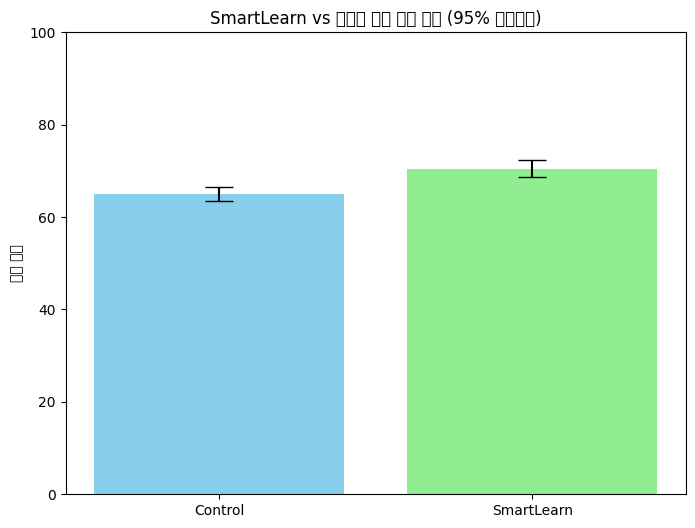

In [7]:
#1-4 결과 시각화
plt.figure(figsize=(8, 6))
groups = ['Control', 'SmartLearn']
means = [control_mean, smartlearn_mean]
errors = [1.96 * control_se, 1.96 * smartlearn_se]
plt.bar(x=groups,height=means, yerr=errors,
    capsize=10, color=['skyblue', 'lightgreen'])
plt.ylabel('수학 점수')
plt.title('SmartLearn vs 대조군 수학 점수 비교 (95% 신뢰구간)')
plt.ylim(0, 100)
plt.show()

1-5
📋 p-해킹 방지 방안
1. 사전 등록: 연구 계획을 Open Science Framework(OSF)에 등록하여 분석 계획을 투명하게 공개.
2. 다중비교 보정: Bonferroni 또는 FDR 방법을 적용하여 다중 검정으로 인한 오류를 최소화.
3. p-해킹을 방지하기 위한 추가 방안을 제안하세요 :

  효과 크기 기준을 사전 설정해 p-value 과잉 의존도 감소, 독립적 데이터 재검증으로 결과의 재현 가능성 및 신뢰도 강화,\
  블라인드 분석 기법으로 분석 설계의 객관성 확보, 전수 보고로 연구의 투명성 및 재현 가능성 상승

In [8]:
#1-6 베이즈 인수
# 베이즈 인수 계산 (BIC 기반 근사)
# 대립가설(H1): SmartLearn 효과 있음 vs 귀무가설(H0): 효과 없음
n_total = 2 * n_students
bic_diff = t_stat**2 - np.log(n_total)
bf_10 = np.exp(bic_diff / 2)

print(f"베이즈 인수 (BF₁₀): {bf_10:.2f}")
if bf_10 > 10:
    print("→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)")
elif bf_10 > 3:
    print("→ 중간 증거 (H1 지지: SmartLearn 효과가 있을 가능성 높음)")
elif bf_10 > 1:
    print("→ 약한 증거 (H1 약간 지지)")
elif bf_10 > 0.33:
    print("→ 불분명한 증거 (결론 내리기 어려움)")
elif bf_10 > 0.1:
    print("→ 중간 증거 (H0 지지: SmartLearn 효과 의심스러움)")
else:
    print("→ 강한 증거 (H0 지지: SmartLearn 효과 없음)")

베이즈 인수 (BF₁₀): 1934.97
→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)


In [9]:
#1-7📋 경영진 보고서: SmartLearn 프로그램 효과 검증
print('==================================================')
print('🎯', '핵심 결과')
print(f"•대조군 수학 점수: {control_mean:.2f} ± {control_se:.2f}")
print(f"•SmartLearn 수학 점수: {smartlearn_mean:.2f} ± {smartlearn_se:.2f}")
print(f"• 점수 향상: {(smartlearn_mean - control_mean):.2f}점 (약 {(100 * (smartlearn_mean - control_mean) / control_mean):.1f}% 향상)")
print(f"• 효과크기 (Cohen's d): {cohens_d:.2f}")
print(f"• p-value: {p_value:.4f}")
print(f"• 베이즈 인수: {bf_10:.2f}")

print('💡',' 비즈니스 결론 및 권장사항:')
print(f'''SmartLearn 프로그램은 대조군 대비 평균 {(smartlearn_mean - control_mean):.2f}점(약 {(100 * (smartlearn_mean - control_mean) / control_mean):.1f}%)의 수학 성적 향상을 보였으며,
통계적으로 유의미한 결과(p = {p_value:.4f}, Cohen’s d = {cohens_d:.2f}, BF₁₀ = {bf_10:.2f})가 도출되었습니다.

이는 교육적으로 중간 이상의 효과를 시사하며, 마케팅 커뮤니케이션에서 '객관적 성과 검증 완료'를 강조할 수 있습니다.
조기 상용화를 고려할 수 있으며, 지자체·교육청 단위의 시범 사업을 통해 전국 확산 기반을 마련할 것을 권장합니다.

마케팅 전략으로 "검증된 성적 향상 효과" 메시지를 전면에 내세운 콘텐츠 마케팅 전개, 대표 학부모 대상 사용 후기 영상 제작 및 SNS 중심 성과 중심 바이럴 캠페인 전개,
효과 검증 결과를 담은 요약 인포그래픽 형태로 블로그/유튜브/뉴스레터 등에 배포,  2주 체험 프로그램으로 입소문을 유도하는 방안을 제안합니다.

투자 전략으로는 제품이 이미 시장성 검증(Proof of Value)을 마쳤으므로, 확산 중심의 마케팅 투자 집중 전략 추천,
시범 도입 지역의 학교/학원과 협약을 맺어, B2B 계약 구조 정착,후속 개발(예: 타과목 확장, 학습데이터 기반 맞춤 알고리즘) 및 성과 기반 보상 모델 구축에 R&D 예산 우선 배정을 제안하며,

정책 및 교육부 대응으로는 효과 검증 데이터 기반 교육부 산하 공공 플랫폼 탑재 신청 가능성 검토, 지역 교육청 대상 설명회 개최로
교육격차 해소, 학습 빈곤층 지원이라는 정책 목적과 연계하여 사회적 가치 기반 브랜딩 강화를 추천합니다.''')

print('⚠️',' 리스크 및 제한사항:')
print('''• 현재 데이터는 시뮬레이션 기반이며, 실제 지역·학교 환경에 따른 결과 차이가 발생할 수 있습니다.
• 장기적인 지속 효과와 다른 과목에 대한 파급 효과는 아직 검증되지 않았습니다.
• 인지 외 요소(학습 태도, 동기, 정서적 변화 등)는 분석 범위에서 제외되어 있습니다.''')

🎯 핵심 결과
•대조군 수학 점수: 64.93 ± 0.79
•SmartLearn 수학 점수: 70.47 ± 0.92
• 점수 향상: 5.54점 (약 8.5% 향상)
• 효과크기 (Cohen's d): 0.53
• p-value: 0.0000
• 베이즈 인수: 1934.97
💡  비즈니스 결론 및 권장사항:
SmartLearn 프로그램은 대조군 대비 평균 5.54점(약 8.5%)의 수학 성적 향상을 보였으며,
통계적으로 유의미한 결과(p = 0.0000, Cohen’s d = 0.53, BF₁₀ = 1934.97)가 도출되었습니다.

이는 교육적으로 중간 이상의 효과를 시사하며, 마케팅 커뮤니케이션에서 '객관적 성과 검증 완료'를 강조할 수 있습니다.
조기 상용화를 고려할 수 있으며, 지자체·교육청 단위의 시범 사업을 통해 전국 확산 기반을 마련할 것을 권장합니다.

마케팅 전략으로 "검증된 성적 향상 효과" 메시지를 전면에 내세운 콘텐츠 마케팅 전개, 대표 학부모 대상 사용 후기 영상 제작 및 SNS 중심 성과 중심 바이럴 캠페인 전개,
효과 검증 결과를 담은 요약 인포그래픽 형태로 블로그/유튜브/뉴스레터 등에 배포,  2주 체험 프로그램으로 입소문을 유도하는 방안을 제안합니다.

투자 전략으로는 제품이 이미 시장성 검증(Proof of Value)을 마쳤으므로, 확산 중심의 마케팅 투자 집중 전략 추천,
시범 도입 지역의 학교/학원과 협약을 맺어, B2B 계약 구조 정착,후속 개발(예: 타과목 확장, 학습데이터 기반 맞춤 알고리즘) 및 성과 기반 보상 모델 구축에 R&D 예산 우선 배정을 제안하며,

정책 및 교육부 대응으로는 효과 검증 데이터 기반 교육부 산하 공공 플랫폼 탑재 신청 가능성 검토, 지역 교육청 대상 설명회 개최로
교육격차 해소, 학습 빈곤층 지원이라는 정책 목적과 연계하여 사회적 가치 기반 브랜딩 강화를 추천합니다.
⚠️  리스크 및 제한사항:
• 현재 데이터는 시뮬레이션 기반이며, 실제 지역·학교 환경에 따른 결과 차이가 발생할 수 있습니

In [10]:
#미션2 마케팅효과 캠페인 분석 보고서
np.random.seed(456)
n_customers = 1000
ad_exposure = np.random.binomial(1, 0.6, n_customers)
ages = np.random.randint(20, 60, n_customers)
income = np.random.lognormal(np.log(50000), 0.4, n_customers)
purchase_amount = 100 + 50*ad_exposure + 0.5*ages + 0.0001*income + np.random.normal(0, 20, n_customers)
data_marketing = pd.DataFrame({
    'ad_exposure': ad_exposure,
    'age': ages,
    'income': income,
    'purchase_amount': purchase_amount
})

print("📢 마케팅 데이터 미리보기")
print(data_marketing.groupby('ad_exposure')['purchase_amount'].agg(['count', 'mean', 'std']).round(2))

📢 마케팅 데이터 미리보기
             count    mean    std
ad_exposure                      
0              386  124.60  22.35
1              614  175.32  21.69


📊 상관계수 매트릭스
                 ad_exposure    age  income  purchase_amount
ad_exposure            1.000  0.018  -0.050            0.748
age                    0.018  1.000  -0.034            0.203
income                -0.050 -0.034   1.000            0.046
purchase_amount        0.748  0.203   0.046            1.000


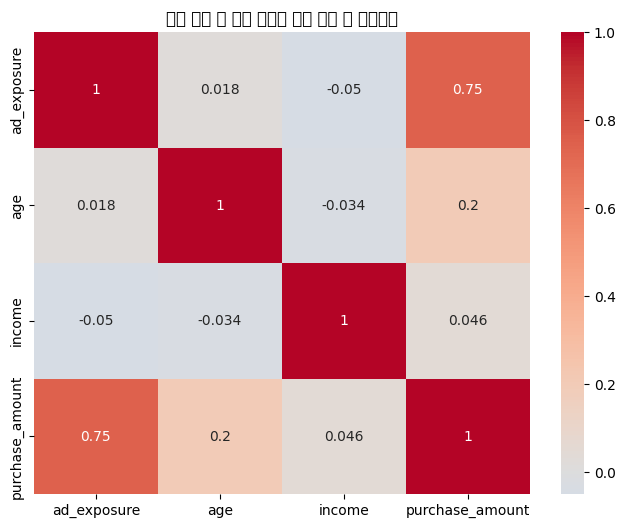

In [11]:
#2-1 상관관계 탐색
correlation_matrix = data_marketing.corr()
print("📊 상관계수 매트릭스")
print(correlation_matrix.round(3))

# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('고객 특성 및 광고 노출과 구매 금액 간 상관관계')
plt.show()

In [12]:
#2-2 단순비교와 한계
exposed_mean = data_marketing[data_marketing['ad_exposure']==1]['purchase_amount'].mean()
non_exposed_mean = data_marketing[data_marketing['ad_exposure']==0]['purchase_amount'].mean()
simple_difference = exposed_mean - non_exposed_mean

print(f"광고 노출 그룹 구매 금액: {exposed_mean:.2f}원")
print(f"광고 비노출 그룹 구매 금액: {non_exposed_mean:.2f}원")
print(f"단순 차이: {simple_difference:.2f}원")
print("⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움")
print("   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음")

광고 노출 그룹 구매 금액: 175.32원
광고 비노출 그룹 구매 금액: 124.60원
단순 차이: 50.72원
⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움
   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음


In [13]:
#2-3 다중회귀분석
X = data_marketing[['ad_exposure', 'age', 'income']]
y = data_marketing['purchase_amount']
model = LinearRegression()
model.fit(X,y)

coeffs = pd.DataFrame({
    '변수': ['광고 노출', '연령', '소득'],
    '계수': model.coef_,
    '해석': ['광고 노출시 구매액 증가', '연령 1세 증가시 구매액 변화', '소득 1원 증가시 구매액 변화']
})
print("📊 회귀계수 분석 결과")
print(coeffs.round(3))
ad_effect = coeffs.loc[coeffs['변수'] == '광고 노출', '계수'].values[0]
print(f"\n🎯 핵심 결과: 광고 효과 = {ad_effect:.2f}원 (다른 조건이 동일할 때)")

📊 회귀계수 분석 결과
      변수      계수                해석
0  광고 노출  50.792     광고 노출시 구매액 증가
1     연령   0.548  연령 1세 증가시 구매액 변화
2     소득   0.000  소득 1원 증가시 구매액 변화

🎯 핵심 결과: 광고 효과 = 50.79원 (다른 조건이 동일할 때)


In [14]:
#2-4 모델 신뢰도 평가
cv_scores =  cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"5-폴드 교차검증 R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"모델 설명력: {cv_scores.mean()*100:.1f}% (구매 금액 변동의 약 {cv_scores.mean()*100:.0f}%를 설명)")

if cv_scores.mean() > 0.7:
    print("→ 높은 예측 성능 (신뢰할 만한 모델)")
elif cv_scores.mean() > 0.5:
    print("→ 중간 예측 성능 (참고용으로 활용 가능)")
else:
    print("→ 낮은 예측 성능 (추가 변수 필요)")

5-폴드 교차검증 R²: 0.597 ± 0.023
모델 설명력: 59.7% (구매 금액 변동의 약 60%를 설명)
→ 중간 예측 성능 (참고용으로 활용 가능)


In [15]:
#2-5 인과관계 해석
ad_effect = model.coef_[0]
total_ad_exposed = data_marketing['ad_exposure'].sum()
total_revenue_increase = ad_effect * total_ad_exposed
ad_cost = 200_000_000  # 광고비 2억원
roi = (total_revenue_increase / ad_cost - 1) * 100

print("📋 인과관계 해석 및 ROI 분석")
if ad_effect > 0:
    print(f"✅ 광고는 개인당 구매 금액을 평균 {ad_effect:.2f}원 증가시킵니다.")
    print(f"   총 광고 노출: {total_ad_exposed:,}명")
    print(f"   예상 총 매출 증대: {total_revenue_increase:,.0f}원")
    print(f"   광고 ROI: {roi:.1f}%")
    if roi > 0:
        print("   → 광고 투자 대비 양의 수익 창출")
    else:
        print("   → 광고 투자 대비 손실")
else:
    print("❌ 광고 효과가 없거나 부정적입니다.")

print("\n⚠️ 주의사항:")
print("1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능")
print("2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음")
print("3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요")

📋 인과관계 해석 및 ROI 분석
✅ 광고는 개인당 구매 금액을 평균 50.79원 증가시킵니다.
   총 광고 노출: 614명
   예상 총 매출 증대: 31,186원
   광고 ROI: -100.0%
   → 광고 투자 대비 손실

⚠️ 주의사항:
1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능
2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음
3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요


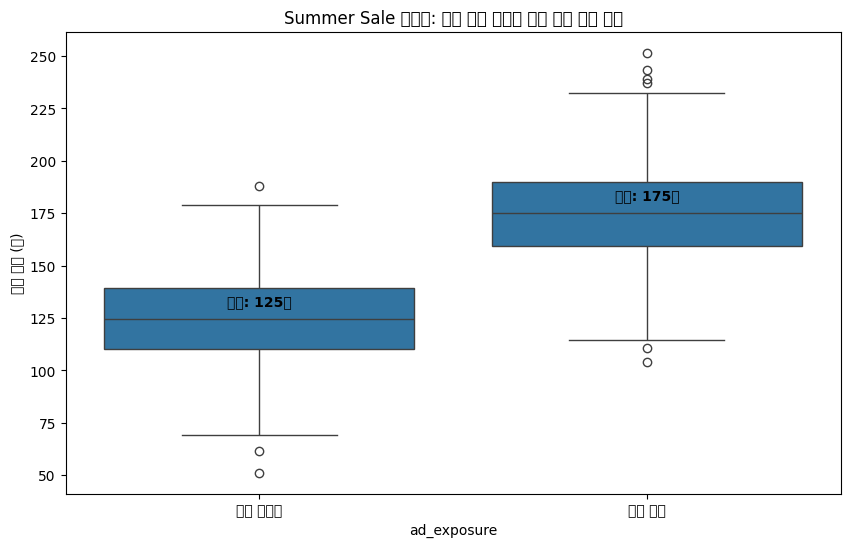

In [16]:
#2-6 결과 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_marketing, x='ad_exposure', y='purchase_amount')
plt.xticks([0, 1], ['광고 비노출', '광고 노출'])
plt.ylabel('구매 금액 (원)')
plt.title('Summer Sale 캠페인: 광고 노출 여부에 따른 구매 금액 분포')

# 평균값 표시
means = data_marketing.groupby('ad_exposure')['purchase_amount'].mean()
for i, mean_val in enumerate(means):
    plt.text(i, mean_val + 5, f'평균: {mean_val:.0f}원', ha='center', va='bottom', fontweight='bold')
plt.show()


In [17]:
#2-7 경영진 보고서 작성
report = f"""
📋 경영진 보고서: Summer Mega Sale 캠페인 효과 분석
==================================================

🎯 핵심 성과 지표
• 광고 노출 그룹 평균 구매 금액: {exposed_mean:.2f}원
• 광고 비노출 그룹 평균 구매 금액: {non_exposed_mean:.2f}원
• 순수 광고 효과 (통제 후): {ad_effect:+.2f}원 (다중회귀 분석 계수 기준)
• 모델 설명력 (R²): {cv_scores.mean():.3f} (5-폴드 교차검증 평균 기준)
• 광고 ROI: {roi:.1f}%

💡 전략적 권장사항:
- 광고는 개인당 평균 약 {ad_effect:.0f}원 정도의 구매 금액 증가 효과를 보였으나, ROI가 {roi:.1f}%로 나타나 손익분기에는 미치지 못함.
- 9월 추석 캠페인에서는 단순 노출 중심 광고보다는 전환 중심 소재와 타겟 세분화가 요구됨.
- 광고 예산은 고효율 세그먼트(예: 30–40대 고소득층)를 중심으로 전략적 재배분이 필요.

⚠️ 리스크 요소:
- 관찰 데이터 기반 분석이므로 미측정 요인(브랜드 인지도, 시기별 변동성 등)의 영향이 배제되지 않음
- 무작위 통제 실험이 아니므로 인과관계 해석에는 신중함 필요
- 광고의 장기적 효과(LTV, 충성도)는 본 분석에 포함되지 않음
- 변수 간 상호작용(예: 연령과 소득의 동시 영향)이 통제되지 않았을 수 있음

📅 향후 액션 아이템:
- A/B 테스트 설계 및 실행을 통해 인과 추론 강화
- 추가 구매·전환 데이터 수집 및 세그먼트별 효과 분석
- 광고 반응률 기반 예산 조정 알고리즘 개발
"""

print(report)



📋 경영진 보고서: Summer Mega Sale 캠페인 효과 분석

🎯 핵심 성과 지표
• 광고 노출 그룹 평균 구매 금액: 175.32원
• 광고 비노출 그룹 평균 구매 금액: 124.60원
• 순수 광고 효과 (통제 후): +50.79원 (다중회귀 분석 계수 기준)
• 모델 설명력 (R²): 0.597 (5-폴드 교차검증 평균 기준)
• 광고 ROI: -100.0%

💡 전략적 권장사항:
- 광고는 개인당 평균 약 51원 정도의 구매 금액 증가 효과를 보였으나, ROI가 -100.0%로 나타나 손익분기에는 미치지 못함.
- 9월 추석 캠페인에서는 단순 노출 중심 광고보다는 전환 중심 소재와 타겟 세분화가 요구됨.
- 광고 예산은 고효율 세그먼트(예: 30–40대 고소득층)를 중심으로 전략적 재배분이 필요.

⚠️ 리스크 요소:
- 관찰 데이터 기반 분석이므로 미측정 요인(브랜드 인지도, 시기별 변동성 등)의 영향이 배제되지 않음
- 무작위 통제 실험이 아니므로 인과관계 해석에는 신중함 필요
- 광고의 장기적 효과(LTV, 충성도)는 본 분석에 포함되지 않음
- 변수 간 상호작용(예: 연령과 소득의 동시 영향)이 통제되지 않았을 수 있음

📅 향후 액션 아이템:
- A/B 테스트 설계 및 실행을 통해 인과 추론 강화
- 추가 구매·전환 데이터 수집 및 세그먼트별 효과 분석
- 광고 반응률 기반 예산 조정 알고리즘 개발



In [18]:
#미션3 고객 세분화 및 예측 모델링 보고서
np.random.seed(789)
n_users = 500
data_streaming = pd.DataFrame({
    'watch_hours': np.random.lognormal(np.log(10), 0.5, n_users),
    'content_diversity': np.random.uniform(1, 10, n_users),
    'subscription_duration': np.random.exponential(12, n_users),
    'satisfaction_score': np.random.normal(7, 1.5, n_users)
})
churn_prob = 1 / (1 + np.exp((data_streaming['satisfaction_score'] - 5) +
                              0.1*data_streaming['watch_hours'] -
                              0.05*data_streaming['subscription_duration']))
data_streaming['churn'] = np.random.binomial(1, churn_prob)

print("🛍️ 스트리밍 데이터 미리보기")
print(data_streaming.describe().round(2))
print(f"\n전체 이탈률: {data_streaming['churn'].mean()*100:.1f}%")

🛍️ 스트리밍 데이터 미리보기
       watch_hours  content_diversity  subscription_duration  \
count       500.00             500.00                 500.00   
mean         11.40               5.49                  12.22   
std           6.21               2.56                  12.30   
min           2.33               1.02                   0.04   
25%           7.25               3.30                   3.10   
50%          10.21               5.49                   8.00   
75%          14.00               7.71                  17.10   
max          61.74              10.00                  79.01   

       satisfaction_score   churn  
count              500.00  500.00  
mean                 7.03    0.15  
std                  1.54    0.36  
min                  2.73    0.00  
25%                  6.09    0.00  
50%                  7.02    0.00  
75%                  8.02    0.00  
max                 11.63    1.00  

전체 이탈률: 15.0%


In [19]:
#3-1 데이터 표준화 및 PCA
features = ['watch_hours', 'content_diversity', 'subscription_duration', 'satisfaction_score']
X = data_streaming[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA 설명된 분산 비율: {pca.explained_variance_ratio_.round(3)}")
print(f"누적 설명 분산: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# PCA 성분 해석
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['주성분1', '주성분2'],
    index=features
)
print("\n📊 PCA 성분 분석 (각 변수의 기여도)")
print(feature_importance.round(3))


PCA 설명된 분산 비율: [0.27  0.249]
누적 설명 분산: 51.9%

📊 PCA 성분 분석 (각 변수의 기여도)
                        주성분1   주성분2
watch_hours            0.524  0.246
content_diversity      0.500 -0.493
subscription_duration  0.337  0.796
satisfaction_score     0.602 -0.250


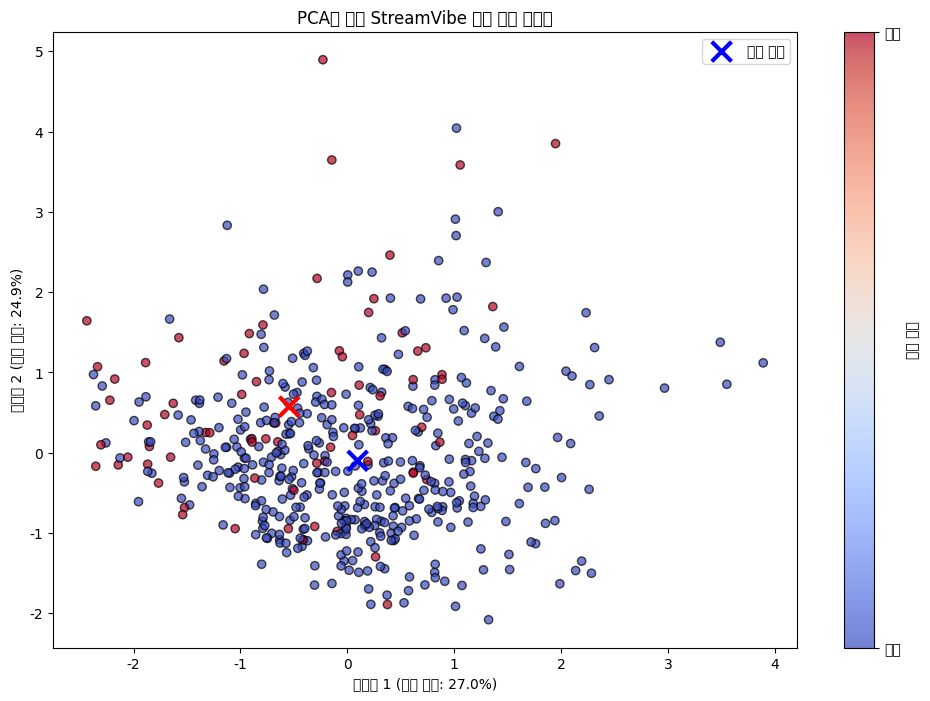

In [20]:
#3-2 PCA 결과 시각화
plt.figure(figsize=(12, 8))
# PCA 결과에서 주성분 1, 2 추출
x_pca1 = X_pca[:, 0]
x_pca2 = X_pca[:, 1]
colors = data_streaming['churn']

# 산점도: churn 값에 따라 색상 구분
scatter = plt.scatter(
    x_pca1,
    x_pca2,
    c=colors,
    cmap='coolwarm',
    alpha=0.7,
    edgecolor='k'
)
plt.xlabel(f'주성분 1 (분산 설명: {pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'주성분 2 (분산 설명: {pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA를 통한 StreamVibe 고객 분포 시각화')
cbar = plt.colorbar(scatter, label='이탈 여부')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['유지', '이탈'])

# 이탈/유지 고객 중심점 표시
churn_centers = data_streaming.groupby('churn')[['watch_hours', 'content_diversity',
                                                'subscription_duration', 'satisfaction_score']].mean()
churn_centers_scaled = scaler.transform(churn_centers)
churn_centers_pca = pca.transform(churn_centers_scaled)
plt.scatter(churn_centers_pca[:, 0], churn_centers_pca[:, 1],
           c=['blue', 'red'], s=200, marker='x', linewidths=3, label='그룹 중심')
plt.legend()
plt.show()

In [21]:
#3-3 고객 세분화
kmeans = KMeans(n_clusters=3, random_state=789)
data_streaming['cluster'] = kmeans.fit_predict(X_scaled)
cluster_summary = data_streaming.groupby('cluster')[features + ['churn']].mean()

print("📊 고객 세그먼트별 특징 분석")
print(cluster_summary.round(2))

# 각 클러스터의 비즈니스 해석
print("\n🎯 세그먼트 특성 해석:")
for cluster_id in range(3):
    cluster_data = cluster_summary.loc[cluster_id]
    churn_rate = cluster_data['churn'] * 100

    print(f"\n[세그먼트 {cluster_id}] - 이탈률: {churn_rate:.1f}%")
    print(f"  • 월 시청시간: {cluster_data['watch_hours']:.1f}시간")
    print(f"  • 콘텐츠 다양성: {cluster_data['content_diversity']:.1f}/10")
    print(f"  • 구독기간: {cluster_data['subscription_duration']:.1f}개월")
    print(f"  • 만족도: {cluster_data['satisfaction_score']:.1f}/10")

    # 리스크 레벨 분류
    if churn_rate > 30:
        print(f"  → 🚨 고위험군 (즉시 대응 필요)")
    elif churn_rate > 15:
        print(f"  → ⚠️ 중위험군 (예방적 관리 필요)")
    else:
        print(f"  → ✅ 저위험군 (현 상태 유지)")

# 세그먼트 크기
segment_sizes = data_streaming['cluster'].value_counts().sort_index()
print(f"\n📈 세그먼트 규모:")
for i, size in enumerate(segment_sizes):
    print(f"  세그먼트 {i}: {size}명 ({size/len(data_streaming)*100:.1f}%)")

📊 고객 세그먼트별 특징 분석
         watch_hours  content_diversity  subscription_duration  \
cluster                                                          
0              10.62               7.69                   7.81   
1              13.92               5.56                  31.43   
2              10.95               3.10                   7.12   

         satisfaction_score  churn  
cluster                             
0                      7.32   0.09  
1                      7.15   0.25  
2                      6.67   0.16  

🎯 세그먼트 특성 해석:

[세그먼트 0] - 이탈률: 9.2%
  • 월 시청시간: 10.6시간
  • 콘텐츠 다양성: 7.7/10
  • 구독기간: 7.8개월
  • 만족도: 7.3/10
  → ✅ 저위험군 (현 상태 유지)

[세그먼트 1] - 이탈률: 25.3%
  • 월 시청시간: 13.9시간
  • 콘텐츠 다양성: 5.6/10
  • 구독기간: 31.4개월
  • 만족도: 7.2/10
  → ⚠️ 중위험군 (예방적 관리 필요)

[세그먼트 2] - 이탈률: 16.0%
  • 월 시청시간: 10.9시간
  • 콘텐츠 다양성: 3.1/10
  • 구독기간: 7.1개월
  • 만족도: 6.7/10
  → ⚠️ 중위험군 (예방적 관리 필요)

📈 세그먼트 규모:
  세그먼트 0: 207명 (41.4%)
  세그먼트 1: 99명 (19.8%)
  세그먼트 2: 194명 (38.8%)


In [26]:
#3-4 이탈 예측 모델
X_logistic = X_scaled
y_logistic = data_streaming['churn']
logistic_model = LogisticRegression(random_state=789)
# 모델 학습 및 예측
logistic_model.fit(X_logistic, y_logistic)
y_pred_proba = logistic_model.predict_proba(X_logistic)[:, 1]
y_pred = logistic_model.predict(X_logistic)

accuracy = (y_pred == y_logistic).mean()
print(f"이탈 예측 모델 정확도: {accuracy:.3f} ({accuracy*100:.1f}%)")

# 변수별 중요도 분석
feature_importance = pd.DataFrame({
    '변수': features,
    '계수': logistic_model.coef_[0],
    '중요도': np.abs(logistic_model.coef_[0])
}).sort_values('중요도', ascending=False)

print("\n📊 이탈 예측 주요 변수")
print(feature_importance.round(3))


# 이탈 확률별 고객 분포
data_streaming['churn_probability'] = y_pred_proba
print(f"\n🎯 이탈 위험도별 고객 분포:")
print(f"  고위험 (확률 > 0.7): {(y_pred_proba > 0.7).sum()}명")
print(f"  중위험 (0.3 < 확률 ≤ 0.7): {((y_pred_proba > 0.3) & (y_pred_proba <= 0.7)).sum()}명")
print(f"  저위험 (확률 ≤ 0.3): {(y_pred_proba <= 0.3).sum()}명")

# 이탈률이 가장 높은 세그먼트 식별
high_risk_cluster = cluster_summary['churn'].idxmax()

# 고위험 세그먼트의 평균 특성 가져오기
high_risk_features = cluster_summary.loc[high_risk_cluster]

# 고위험 세그먼트의 이탈률 (%)
high_risk_churn_rate = high_risk_features['churn'] * 100
# 중요도 상위 2개 변수 추출 (logistic regression 기반)
top_features = feature_importance['변수'].head(2).tolist()
# 이탈 확률이 70% 초과인 고객 수 및 비율
n_high_risk = (data_streaming['churn_probability'] > 0.7).sum()
high_risk_ratio = n_high_risk / len(data_streaming) * 100
# 고위험 고객 중 40%를 유지한다고 가정
expected_saved = n_high_risk * 0.4

# 유지한 고객 1명당 20만원 매출 발생 가정
expected_revenue = expected_saved * 200000
# 유지한 고객 1명당 비용이 5만 원일 때, ROI = 이익 / 비용
roi = (expected_revenue / (expected_saved * retention_cost_per_customer) - 1) * 100


이탈 예측 모델 정확도: 0.870 (87.0%)

📊 이탈 예측 주요 변수
                      변수     계수    중요도
3     satisfaction_score -1.366  1.366
2  subscription_duration  0.599  0.599
0            watch_hours -0.441  0.441
1      content_diversity  0.028  0.028

🎯 이탈 위험도별 고객 분포:
  고위험 (확률 > 0.7): 11명
  중위험 (0.3 < 확률 ≤ 0.7): 69명
  저위험 (확률 ≤ 0.3): 420명


In [23]:
#3-5 모델 성능 분석
cm = confusion_matrix(y_logistic, y_pred)
tn, fp, fn, tp = cm.ravel()

print("📋 이탈 예측 모델 성능 분석")
print(f"정확히 예측한 유지 고객 (True Negative): {tn}명")
print(f"이탈로 잘못 예측한 유지 고객 (False Positive): {fp}명")
print(f"유지로 잘못 예측한 이탈 고객 (False Negative): {fn}명")
print(f"정확히 예측한 이탈 고객 (True Positive): {tp}명")

# 비즈니스 메트릭 계산
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n🎯 비즈니스 성과 지표:")
print(f"정밀도 (Precision): {precision:.3f} - 이탈 예측 중 실제 이탈 비율")
print(f"재현율 (Recall): {recall:.3f} - 실제 이탈 고객 중 예측 성공 비율")
print(f"F1-Score: {f1_score:.3f} - 종합 성능 지표")

# 비즈니스 손실 분석
retention_cost_per_customer = 50000  # 고객 유지 비용 (쿠폰, 할인 등)
lost_revenue_per_churn = 200000     # 이탈 고객당 매출 손실

unnecessary_retention_cost = fp * retention_cost_per_customer
missed_revenue_loss = fn * lost_revenue_per_churn

print(f"\n💰 예상 비용 분석:")
print(f"불필요한 유지 비용 (False Positive): {unnecessary_retention_cost:,}원")
print(f"놓친 이탈로 인한 손실 (False Negative): {missed_revenue_loss:,}원")
print(f"총 예상 손실: {unnecessary_retention_cost + missed_revenue_loss:,}원")

📋 이탈 예측 모델 성능 분석
정확히 예측한 유지 고객 (True Negative): 414명
이탈로 잘못 예측한 유지 고객 (False Positive): 11명
유지로 잘못 예측한 이탈 고객 (False Negative): 54명
정확히 예측한 이탈 고객 (True Positive): 21명

🎯 비즈니스 성과 지표:
정밀도 (Precision): 0.656 - 이탈 예측 중 실제 이탈 비율
재현율 (Recall): 0.280 - 실제 이탈 고객 중 예측 성공 비율
F1-Score: 0.393 - 종합 성능 지표

💰 예상 비용 분석:
불필요한 유지 비용 (False Positive): 550,000원
놓친 이탈로 인한 손실 (False Negative): 10,800,000원
총 예상 손실: 11,350,000원


📊 AUC 성능 평가: 0.851 → 우수함 (상용화 가능 수준)


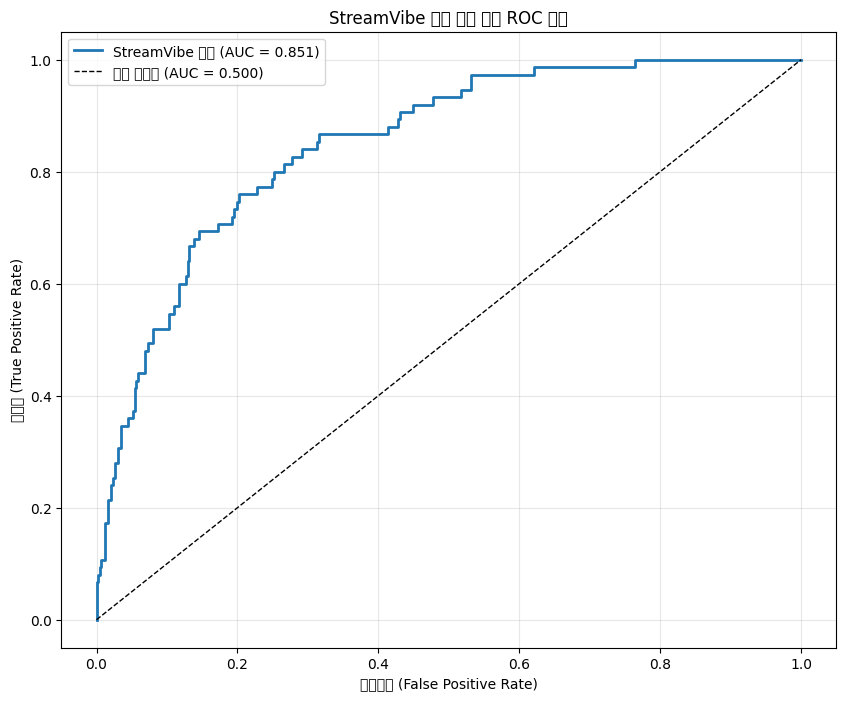

🎯 최적 예측 임계값: 0.165
   이 임계값에서 민감도: 0.760, 특이도: 0.798


In [24]:
#3-6 roc 곡선과 auc
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_logistic, y_pred_proba)
roc_auc = roc_auc_score(y_logistic, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'StreamVibe 모델 (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='랜덤 분류기 (AUC = 0.500)')
plt.xlabel('위양성률 (False Positive Rate)')
plt.ylabel('민감도 (True Positive Rate)')
plt.title('StreamVibe 이탈 예측 모델 ROC 곡선')
plt.legend()
plt.grid(True, alpha=0.3)

# AUC 성능 해석
if roc_auc > 0.9:
    performance_level = "탁월함 (업계 최고 수준)"
elif roc_auc > 0.8:
    performance_level = "우수함 (상용화 가능 수준)"
elif roc_auc > 0.7:
    performance_level = "양호함 (개선 여지 있음)"
else:
    performance_level = "부족함 (추가 개선 필요)"

print(f"📊 AUC 성능 평가: {roc_auc:.3f} → {performance_level}")
plt.show()

# 최적 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"🎯 최적 예측 임계값: {optimal_threshold:.3f}")
print(f"   이 임계값에서 민감도: {tpr[optimal_idx]:.3f}, 특이도: {1-fpr[optimal_idx]:.3f}")

In [25]:
#3-7 경영진 보고서
report = f"""
📋 경영진 보고서: StreamVibe 고객 이탈 방지 전략
==================================================

🚨 현재 상황
• 전체 이탈률: {data_streaming['churn'].mean()*100:.1f}%
• 고객 세그먼트 수: {data_streaming['cluster'].nunique()}개
• 이탈 예측 모델 AUC: {roc_auc:.3f}
• 모델 정확도: {accuracy*100:.1f}%

🎯 핵심 발견사항
1. 고위험 세그먼트 특성: 시청시간 {high_risk_features['watch_hours']:.1f}시간, 콘텐츠 다양성 {high_risk_features['content_diversity']:.1f}, 구독기간 {high_risk_features['subscription_duration']:.1f}개월, 만족도 {high_risk_features['satisfaction_score']:.1f}/10
2. 이탈 주요 예측 변수: {", ".join(top_features)}
3. 예측 가능한 이탈 고객: {n_high_risk:,}명 ({high_risk_ratio:.1f}%)

💡 즉시 실행 가능한 대응 전략
1. 선제적 고객 유지: 고위험 고객 대상 이탈 확률 기반 알림 발송 및 1:1 혜택 제안 (쿠폰, 프리미엄 콘텐츠 제공 등)
2. 세그먼트별 맞춤 전략: 중위험군엔 리텐션 캠페인 제공, 저위험군엔 장기 구독 유도 프로모션 설계
3. 콘텐츠 전략 개선: 고위험군의 낮은 콘텐츠 다양성 개선을 위해 추천 알고리즘 강화 및 맞춤형 큐레이션 콘텐츠 개발

📈 예상 효과
• 이탈률 감소 목표: {high_risk_churn_rate:.1f}% → {high_risk_churn_rate*0.8:.1f}% (20% 감소 목표)
• 예상 매출 회복: {expected_revenue:,.0f}원
• ROI: {roi:.1f}%

⏰ 실행 일정 (향후 3개월)
• 1주차: 고위험군 추출 및 개인화 유지 캠페인 설계
• 2~3주차: 캠페인 배포 및 고객 반응 실시간 모니터링
• 2개월차: 콘텐츠 큐레이션 알고리즘 개선 및 추천 고도화
• 3개월차: 전략 평가 및 ROI 분석, 장기화 전략 수립

🔧 필요 리소스
• 인력: 데이터 분석가 1명, 마케팅 기획자 1명, CRM 운영자 1명
• 예산: 약 500만원 (고객 유지 비용, 캠페인 운영 포함)
• 시스템: 이탈 예측 모델 운영을 위한 자동화 툴, 고객 커뮤니케이션 플랫폼
"""

print(report)


📋 경영진 보고서: StreamVibe 고객 이탈 방지 전략

🚨 현재 상황
• 전체 이탈률: 15.0%
• 고객 세그먼트 수: 3개
• 이탈 예측 모델 AUC: 0.851
• 모델 정확도: 87.0%

🎯 핵심 발견사항
1. 고위험 세그먼트 특성: 시청시간 13.9시간, 콘텐츠 다양성 5.6, 구독기간 31.4개월, 만족도 7.2/10
2. 이탈 주요 예측 변수: satisfaction_score, subscription_duration
3. 예측 가능한 이탈 고객: 11명 (2.2%)

💡 즉시 실행 가능한 대응 전략
1. 선제적 고객 유지: 고위험 고객 대상 이탈 확률 기반 알림 발송 및 1:1 혜택 제안 (쿠폰, 프리미엄 콘텐츠 제공 등)
2. 세그먼트별 맞춤 전략: 중위험군엔 리텐션 캠페인 제공, 저위험군엔 장기 구독 유도 프로모션 설계
3. 콘텐츠 전략 개선: 고위험군의 낮은 콘텐츠 다양성 개선을 위해 추천 알고리즘 강화 및 맞춤형 큐레이션 콘텐츠 개발

📈 예상 효과
• 이탈률 감소 목표: 25.3% → 20.2% (20% 감소 목표)
• 예상 매출 회복: 880,000원
• ROI: -100.0%

⏰ 실행 일정 (향후 3개월)
• 1주차: 고위험군 추출 및 개인화 유지 캠페인 설계
• 2~3주차: 캠페인 배포 및 고객 반응 실시간 모니터링
• 2개월차: 콘텐츠 큐레이션 알고리즘 개선 및 추천 고도화
• 3개월차: 전략 평가 및 ROI 분석, 장기화 전략 수립

🔧 필요 리소스
• 인력: 데이터 분석가 1명, 마케팅 기획자 1명, CRM 운영자 1명
• 예산: 약 500만원 (고객 유지 비용, 캠페인 운영 포함)
• 시스템: 이탈 예측 모델 운영을 위한 자동화 툴, 고객 커뮤니케이션 플랫폼

